In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


In [16]:
image_path = 'plants dataset\\color\\Grape___healthy\\0ac4ff49-7fbf-4644-98a4-4dc596e2fa87___Mt.N.V_HL 9004.JPG'
# image_path = 'plants dataset\color\\Grape___healthy\\cf021a08-5619-4b8b-9835-c9c03d291875___Mt.N.V_HL 6086.JPG'
original_img = load_img(image_path, target_size=(224, 224))
original_img_array = img_to_array(original_img) / 255.0

In [17]:
datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

transformed_img_array = datagen.random_transform(original_img_array)

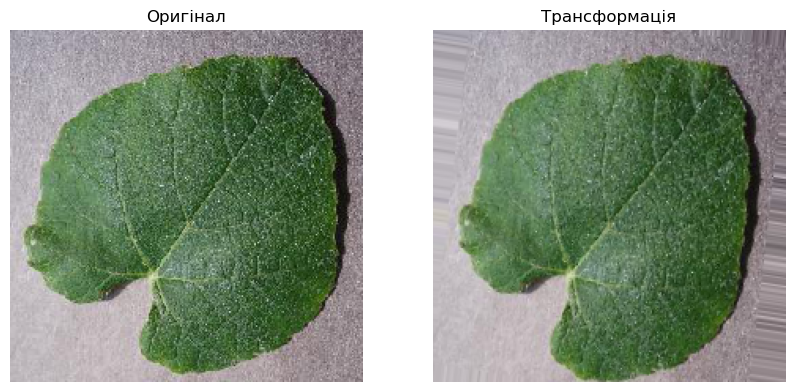

In [18]:
def show_images(original, transformed):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title('Оригінал')
    axes[0].axis('off')
    
    axes[1].imshow(transformed)
    axes[1].set_title('Трансформація')
    axes[1].axis('off')
    
    plt.show()

# Отображение изображений
show_images(original_img_array, transformed_img_array)

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download abdallahalidev/plantvillage-dataset
! unzip -q /content/plantvillage-dataset.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [00:14<00:00, 218MB/s]
100% 2.04G/2.04G [00:14<00:00, 154MB/s]


In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [3]:
import tensorflow as tf
import keras
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization, GlobalAveragePooling2D, Input, multiply, GlobalMaxPooling2D, Flatten
from tensorflow.keras.optimizers import Nadam, AdamW, Adam, Lion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers

In [4]:
source_dir = '/content/plantvillage dataset/color'
target_dir = '/content/my_dataset'


Path(target_dir).mkdir(parents=True, exist_ok=True)
train_dir = os.path.join(target_dir, 'train')
test_dir = os.path.join(target_dir, 'test')
valid_dir = os.path.join(target_dir, 'valid')

for dir_path in [train_dir, test_dir, valid_dir]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

classes = os.listdir(source_dir)


for class_name in classes:
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    train_split = int(0.8 * num_images)
    test_split = int(0.1 * num_images)
    valid_split = num_images - train_split - test_split

    train_images = images[:train_split]
    test_images = images[train_split:train_split+test_split]
    valid_images = images[train_split+test_split:]


    for img_name in train_images:
        src = os.path.join(class_path, img_name)
        dest = os.path.join(train_dir, class_name, img_name)
        Path(os.path.join(train_dir, class_name)).mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dest)

    for img_name in test_images:
        src = os.path.join(class_path, img_name)
        dest = os.path.join(test_dir, class_name, img_name)
        Path(os.path.join(test_dir, class_name)).mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dest)

    for img_name in valid_images:
        src = os.path.join(class_path, img_name)
        dest = os.path.join(valid_dir, class_name, img_name)
        Path(os.path.join(valid_dir, class_name)).mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dest)

In [5]:
def create_dataframe_from_directory(directory):
    filepaths = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):  # Проверяем, что это действительно папка
            for filename in os.listdir(label_dir):
                filepath = os.path.join(label_dir, filename)
                filepaths.append(filepath)
                labels.append(label)  # Используем название папки как метку
    df = pd.DataFrame({'Filepaths': filepaths, 'Labels': labels})
    return df

train_dir = '/content/my_dataset/train'
test_dir = '/content/my_dataset/test'
valid_dir = '/content/my_dataset/valid'

In [6]:
train_df = create_dataframe_from_directory(train_dir)
valid_df = create_dataframe_from_directory(valid_dir)
test_df = create_dataframe_from_directory(test_dir)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2
# )


valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 43429 validated image filenames belonging to 38 classes.
Found 5459 validated image filenames belonging to 38 classes.
Found 5417 validated image filenames belonging to 38 classes.


In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True,
                               mode='max',
                               min_delta=0.01,
                               baseline=0.95)

model_checkpoint = ModelCheckpoint('DenseNet+L.h5',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

# Xception + Nadam

In [9]:
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet',
                                                include_top = False,

                                                     input_shape = (224,224,3),
                                                pooling = 'avg')

for layer in base_model.layers:
    layer.trainable = False


for layer in base_model.layers[-4:]:
    layer.trainable = True

model_Xcep_N = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(38 , activation= 'softmax' )
])

83683744/83683744 [==============================] - 0s 0us/step


In [10]:
model_Xcep_N.compile(optimizer='Nadam',
              loss = 'categorical_crossentropy',
              metrics= ['accuracy'])
model_Xcep_N.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                9766      
                                                                 
Total params: 21403982 (81.65 MB)
Trainable params: 3702054 (14.12 MB)
Non-trainable params: 17701928 (67.53 MB)
_________

In [11]:
history = model_Xcep_N.fit(
    train_generator,
    validation_data= valid_generator,
    epochs= 5,
    verbose = 1,
    shuffle= False,
    callbacks=[early_stopping, model_checkpoint]
    )

Epoch 1/5
1358/1358 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.8062
Epoch 1: val_accuracy improved from -inf to 0.90804, saving model to DenseNet+L.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1358/1358 [==============================] - 611s 440ms/step - loss: 0.7245 - accuracy: 0.8062 - val_loss: 0.2888 - val_accuracy: 0.9080
Epoch 2/5
1357/1358 [============================>.] - ETA: 0s - loss: 0.3910 - accuracy: 0.8870
Epoch 2: val_accuracy improved from 0.90804 to 0.92691, saving model to DenseNet+L.h5
1358/1358 [==============================] - 595s 438ms/step - loss: 0.3909 - accuracy: 0.8871 - val_loss: 0.2454 - val_accuracy: 0.9269
Epoch 3/5
1357/1358 [============================>.] - ETA: 0s - loss: 0.3171 - accuracy: 0.9033Restoring model weights from the end of the best epoch: 2.

Epoch 3: val_accuracy improved from 0.92691 to 0.93277, saving model to DenseNet+L.h5
1358/1358 [==============================] - 601s 443ms/step - loss: 0.3173 - accuracy: 0.9032 - val_loss: 0.2039 - val_accuracy: 0.9328
Epoch 3: early stopping


In [22]:
test_loss, test_accuracy = model_Xcep_N.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

170/170 [==============================] - 24s 142ms/step - loss: 0.2420 - accuracy: 0.9254
Test Accuracy: 0.9254199862480164


In [13]:
model_Xcep_N.save('model_Xcep_N.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NameError: name 'accuracy' is not defined

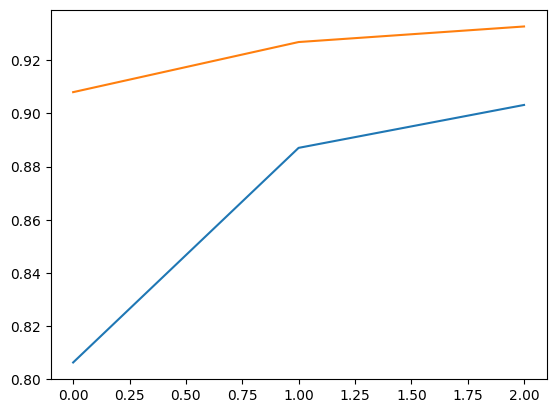

<Figure size 1000x500 with 0 Axes>

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Train')
plt.plot(val_accuracy, label='Validation')
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)

plt.legend(loc='lower right', fontsize=12)
plt.show()

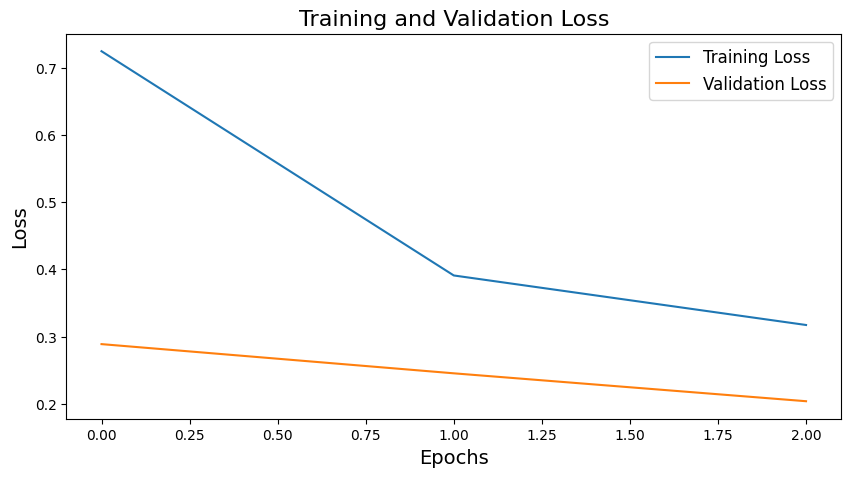

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Створюємо графік
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

plt.show()

In [19]:
test_predictions = model_Xcep_N.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)


test_true_labels = test_generator.classes
error_df = pd.DataFrame({'True Label': test_true_labels, 'Predicted Label': test_predicted_labels})
misclassified_images = error_df[error_df['True Label'] != error_df['Predicted Label']]

170/170 [==============================] - 27s 152ms/step


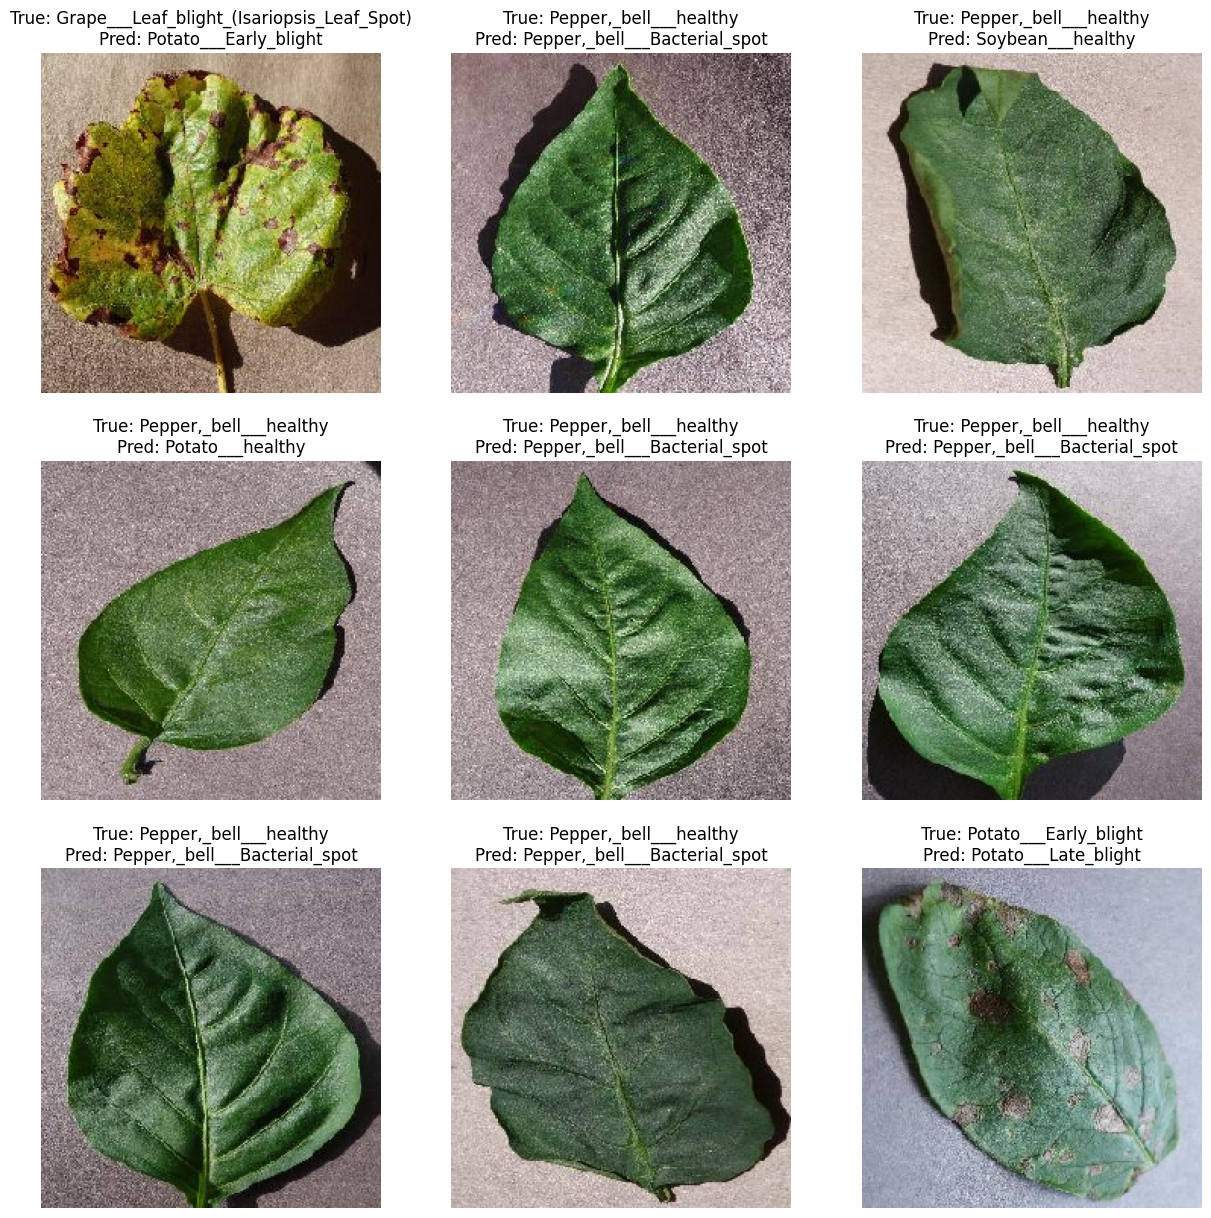

In [20]:
class_folds = {v: k for k, v in train_generator.class_indices.items()}
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 15))
for i, row in enumerate(misclassified_images.head(9).itertuples()):
    img_path = test_df.iloc[row.Index]['Filepaths']
    img = keras_image.load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_label = class_folds[row._1]  # Use 'True Label' as defined in error_df
    pred_label = class_folds[row._2]  # Use 'Predicted Label' as defined in error_df
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

In [21]:
test_generator.reset()
pred = model_Xcep_N.predict(test_generator)
predicted_class_indices = np.argmax(pred, axis=1)

# Get the true labels
true_class_indices = test_generator.classes

# Generate and print the classification report
print(classification_report(true_class_indices, predicted_class_indices, target_names=class_names))

170/170 [==============================] - 23s 135ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.95      0.87      0.91        63
                                 Apple___Black_rot       1.00      0.81      0.89        62
                          Apple___Cedar_apple_rust       1.00      0.93      0.96        27
                                   Apple___healthy       0.85      1.00      0.92       164
                               Blueberry___healthy       0.90      1.00      0.95       150
          Cherry_(including_sour)___Powdery_mildew       0.95      0.97      0.96       105
                 Cherry_(including_sour)___healthy       1.00      0.98      0.99        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.80      0.78      0.79        51
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       119
               Corn_(

# Xception + AdamW


In [33]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True,
                               mode='max',
                               min_delta=0.01,
                               baseline=0.90)

model_checkpoint = ModelCheckpoint('Xcep+AW.h5',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [34]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

for layer in base_model.layers:
    layer.trainable = False


for layer in base_model.layers[-4:]:
    layer.trainable = True

model_Xcep_L = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(38 , activation= 'softmax' )
])

In [35]:
initial_learning_rate = 0.001
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

In [36]:
optimizer = AdamW(learning_rate=schedule, weight_decay=1e-4)
model_Xcep_L.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics= ['accuracy'])
model_Xcep_L.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_29 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 38)                9766      
                                                                 
Total params: 21403982 (81.65 MB)
Trainable params: 3702054 (14.12 MB)
Non-trainable params: 17701928 (67.53 MB)
_______

In [37]:
history = model_Xcep_L.fit(
    train_generator,
    validation_data= valid_generator,
    epochs= 5,
    verbose = 1,
    shuffle= False,
    callbacks=[early_stopping, model_checkpoint]
    )

Epoch 1/5
1357/1358 [============================>.] - ETA: 0s - loss: 0.7384 - accuracy: 0.8057
Epoch 1: val_accuracy improved from -inf to 0.92086, saving model to Xcep+AW.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1358/1358 [==============================] - 658s 481ms/step - loss: 0.7383 - accuracy: 0.8057 - val_loss: 0.2789 - val_accuracy: 0.9209
Epoch 2/5
1357/1358 [============================>.] - ETA: 0s - loss: 0.3807 - accuracy: 0.8876
Epoch 2: val_accuracy improved from 0.92086 to 0.93442, saving model to Xcep+AW.h5
1358/1358 [==============================] - 598s 441ms/step - loss: 0.3809 - accuracy: 0.8876 - val_loss: 0.2107 - val_accuracy: 0.9344
Epoch 3/5
1357/1358 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.9064
Epoch 3: val_accuracy did not improve from 0.93442
1358/1358 [==============================] - 626s 461ms/step - loss: 0.3209 - accuracy: 0.9064 - val_loss: 0.2335 - val_accuracy: 0.9265
Epoch 4/5
1357/1358 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.9155
Epoch 4: val_accuracy improved from 0.93442 to 0.94340, saving model to Xcep+AW.h5
1358/1358 [==============================] - 618s 455ms/step - loss: 0.2859 - acc

In [38]:
model_Xcep_N.save('model_Xcep_AdamW.h5')

In [39]:
test_loss, test_accuracy = model_Xcep_L.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

170/170 [==============================] - 24s 139ms/step - loss: 0.1775 - accuracy: 0.9430
Test Accuracy: 0.94295734167099


In [40]:
test_predictions = model_Xcep_L.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)


test_true_labels = test_generator.classes
error_df = pd.DataFrame({'True Label': test_true_labels, 'Predicted Label': test_predicted_labels})
misclassified_images = error_df[error_df['True Label'] != error_df['Predicted Label']]

170/170 [==============================] - 24s 137ms/step


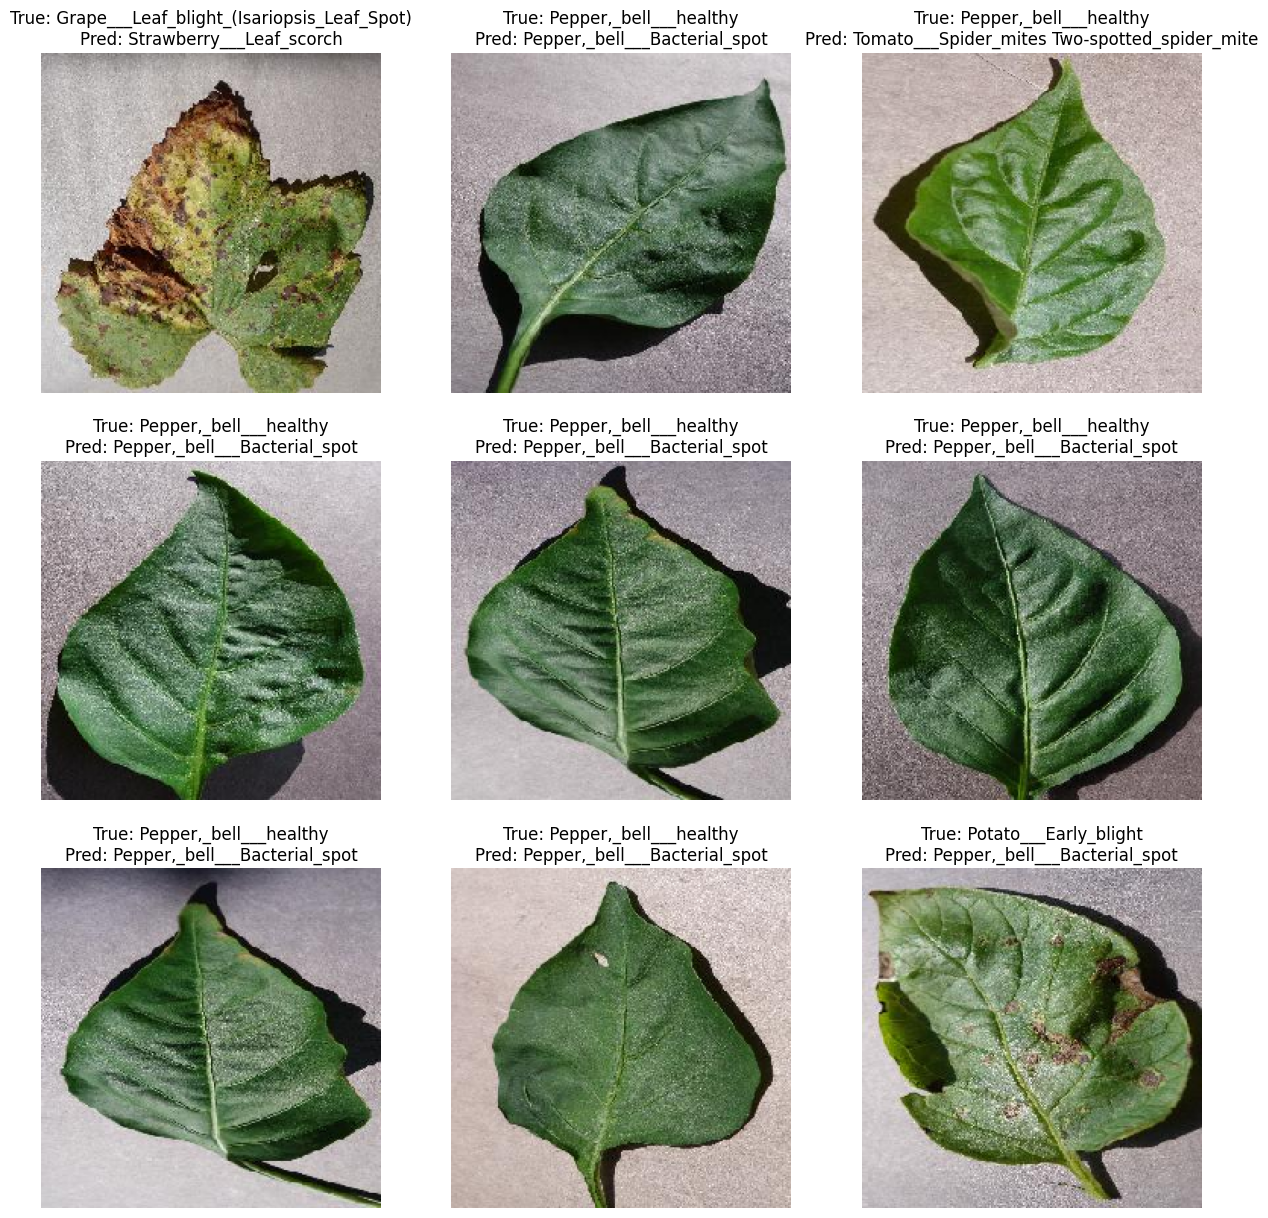

In [41]:
class_folds = {v: k for k, v in train_generator.class_indices.items()}
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 15))
for i, row in enumerate(misclassified_images.head(9).itertuples()):
    img_path = test_df.iloc[row.Index]['Filepaths']
    img = keras_image.load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_label = class_folds[row._1]  # Use 'True Label' as defined in error_df
    pred_label = class_folds[row._2]  # Use 'Predicted Label' as defined in error_df
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

In [42]:
test_generator.reset()
pred = model_Xcep_L.predict(test_generator)
predicted_class_indices = np.argmax(pred, axis=1)

# Get the true labels
true_class_indices = test_generator.classes

# Generate and print the classification report
print(classification_report(true_class_indices, predicted_class_indices, target_names=class_names))


170/170 [==============================] - 23s 136ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.89      0.92      0.91        63
                                 Apple___Black_rot       0.98      0.92      0.95        62
                          Apple___Cedar_apple_rust       0.75      1.00      0.86        27
                                   Apple___healthy       0.97      0.95      0.96       164
                               Blueberry___healthy       0.97      0.99      0.98       150
          Cherry_(including_sour)___Powdery_mildew       1.00      0.97      0.99       105
                 Cherry_(including_sour)___healthy       1.00      0.96      0.98        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.79      0.82      0.81        51
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       119
               Corn_(

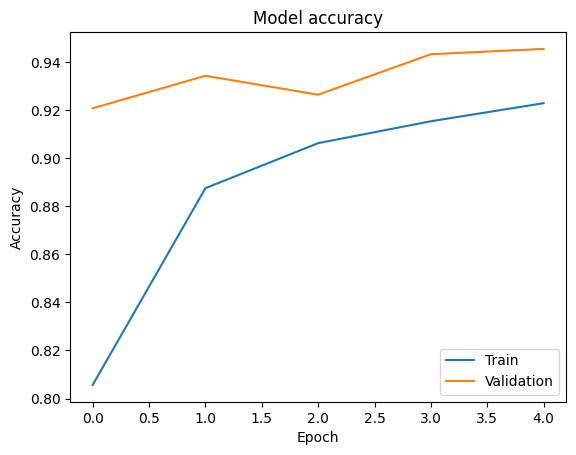

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

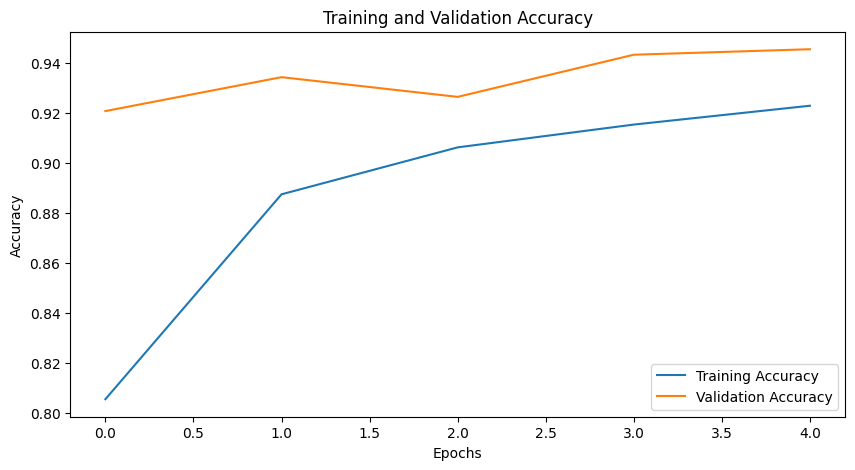

In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Створюємо графік
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MobileNet

In [45]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True,
                               mode='max',
                               min_delta=0.01,
                               baseline=0.95)

model_checkpoint = ModelCheckpoint('MobileNet+AdamW.h5',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [46]:
base_model = MobileNet(weights= 'imagenet',
                       include_top = False,
                       input_shape = (224,224,3),
                       pooling = 'avg')

model2 = Sequential()
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.35))
model2.add(layers.Dense(38, activation='softmax'))
model2.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1024)              3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                65600     
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 38)                

In [47]:
initial_learning_rate = 0.001
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

In [48]:
optimizer = AdamW(learning_rate=schedule, weight_decay=1e-4)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
%%time
history = model2.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 5,
    shuffle= False,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [1]:
import math 

In [4]:
for i in range(10):
    if i == 12:
        break 

    print(i)

0
1
2
3
4
5
6
7
8
9
